In [121]:
#built in librairies 
from tqdm import tqdm

# pip libraires
import numpy as np
import json
import pandas as pd


# visualization librairies
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

# Natural Language Processing Librairies
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import re

# Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Calculating libraries
import scipy as sp

#statistical librairies
import pingouin 

# Import libraries
import requests
from bs4 import BeautifulSoup


#from genres import genre_wordsets
import csv
import datetime  
from dateutil.relativedelta import relativedelta
from utils.genres import additional_wordsets


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/bastienll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bastienll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/bastienll/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Our dataset contains different datasets. We have:
- Metadata
- Plots of Movies
- Characters 


# Metadata

In [3]:
metadata = pd.read_table('./data/movie.metadata.tsv',header=None)
metadata.columns = ["wiki_id","freebase_id","movie_name","release_date","box_office","duration","language","country","genre"]


In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wiki_id       81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   movie_name    81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   box_office    8401 non-null   float64
 5   duration      61291 non-null  float64
 6   language      81741 non-null  object 
 7   country       81741 non-null  object 
 8   genre         81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Here are our observations:
- Box Office contains mainly null values, so we drop the column.
- The type of the release_date is an object, we will transform it into a datetime to make sampling easier.

In [5]:
metadata.drop(columns="box_office",inplace=True)
metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors = 'coerce')


In [6]:
metadata.head(1)

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


We note that language, country, genre are JSONs. Therefore, we nede to transform them into a list

In [7]:
json_cols = ["language","country","genre"]
for col in json_cols:
    metadata[col] = metadata[col].apply(lambda x:list(json.loads(x).values()))

In [8]:
metadata.head()

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,106.0,[German Language],[Germany],[Drama]


In [9]:
ProfileReport(metadata)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### need to make a description of the report

We are aware that the columns can contain list with one value at a time. For simplicity of cleaning, we leave it llike that for the moment.

In [10]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [11]:
genres =pd.Series(flatten_list(list(metadata.genre)))
n_genres = len(set(genres))
print("Number of genres: {} ".format(n_genres))

Number of genres: 363 


We have 363 genres. Some of them are quite specific : Homoeroticism,Silhouette animation and other are more general.
In order to have a deeper analysis for the genres, we need to link every genre into a metagenre. 

Therefore, we have created a mapping to the 363 genres to broader meta-genres.

## Metagenres

In [12]:
def stem_string(x:str)->list:
    """ Returns the stem of every word in the input

    Args:
        x (str): Contains the input to be stemmed

    Returns:
        _type_: a list of the words stemmed
    """
    
    stemmer = LancasterStemmer()
    words = word_tokenize(x)
    lemmatized_words = [stemmer.stem(word) for word in words]
    return lemmatized_words


#TODO NICO: 
- Rename clean_string and clean
- Explain the issue in science fiction in a mwrkdown
- Add type args and return as above

In [13]:
def clean_string(string):
    """_summary_

    Args:
        string (_type_): _description_

    Returns:
        _type_: _description_
    """
    clean_s = string.lower()
    clean_s = clean_s.replace('/', ' ')

    clean_s = re.sub(r'-(?!.*(fi|white))', ' ', clean_s)

    clean_s = re.sub(r'((?<=sci) (?=fi))|((?<=science) (?=fiction))', '-', clean_s)
    # remove everything except alphabets 
    clean_s = re.sub("[^a-zA-Z-]"," ",clean_s) 
    # remove whitespaces 
    clean_s = ' '.join(clean_s.split()) 
    return clean_s


In [14]:
def clean(var):

    out = ''

    if type(var) == list:
        out = var.copy()
        for i,s in enumerate(var):
            out[i] = clean_string(s)
    else :
        if type(var) == dict:
            out = var.copy()
            for key, value in var.items():
                out[clean_string(key)] = clean(value)
        else:
            out = clean_string(var)
    return out

Add explanation of what does the website contains.

Include picture if necessary

In [15]:
URL = 'https://www.studiobinder.com/blog/movie-genres-list/'

# Make the request
r = requests.get(URL) # /ip: Returns the requester's IP Address.


In [16]:
soup = BeautifulSoup(r.text, 'html.parser')
soup.h5.string

publications_wrappers = soup.find_all('div', {"data-css": ["tve-u-16d41491117", "tve-u-16d41ed6dc1", "tve-u-17317362207"]})

print('Total number of items: {0}'.format(len(publications_wrappers)))

genres = dict([])

for p in publications_wrappers[:-1]:    
    sub_g = p.find_all('h5')
    major_genres = p.find_all('h3')

    for g in major_genres :

        m_genre = clean(g.string.rsplit(' ', 1)[0])
        genres[m_genre] = []
        genres[m_genre].append(clean(m_genre))

    for s in sub_g :
        genres[m_genre].append(clean(s.string))

print(genres)

Total number of items: 14
{'action': ['action', 'heroic bloodshed', 'military action', 'espionage', 'wuxia action', 'disaster', 'adventure', 'superhero'], 'animation': ['animation', 'traditional', 'stop motion', 'claymation', 'cutout', 'computer generated imagery', 'puppetry', 'live action'], 'comedy': ['comedy', 'action comedy', 'dark comedy black comedy', 'romantic comedy', 'buddy comedy', 'road comedy', 'slapstick comedy', 'parody', 'spoof', 'satire', 'sitcom', 'sketch comedy', 'mockumentary', 'prank'], 'crime': ['crime', 'caper', 'heist', 'gangster', 'cop police', 'detective', 'courtroom', 'procedural'], 'drama': ['drama', 'melodrama', 'teen drama', 'philosophical drama', 'medical drama', 'legal drama', 'political drama', 'anthropological drama', 'religious drama', 'docudrama'], 'experimental': ['experimental', 'surrealist', 'absurdist'], 'fantasy': ['fantasy', 'contemporary fantasy', 'urban fantasy', 'dark fantasy', 'high fantasy', 'myth'], 'historical': ['historical', 'historical

In [17]:
def clean_confusing_genres(all_genres):

    key_list = list(all_genres.keys())
    key_list = [stem_string(key) for key in key_list]


    values_list = []
    for items in list(all_genres.values()) : 
        values_list += items

    for major_genres, sub_genres in all_genres.items() :
        
        temp_list = values_list.copy()
        stemmed_major_genre = stem_string(major_genres)

        for s_g in sub_genres :
            temp_list.remove(s_g)

            for composed_genres in temp_list :
                if s_g in composed_genres :
                    composed_genres.remove(s_g)
        
        temp_list = [x for x in temp_list if x]

        for s_g in sub_genres :

            for other_genres in temp_list :
                if (other_genres[0] in s_g) and (stemmed_major_genre[0] in s_g) :
                    s_g.remove(other_genres[0])

                if "film" in s_g :
                    s_g.remove("film")

                if "fict" in s_g :
                    s_g.remove("fict")

                for m_genres in key_list :
                    if m_genres[0] in s_g :
                        s_g.remove(m_genres[0])
            
        all_genres[major_genres].append(stemmed_major_genre)   
                
        all_genres[major_genres] = [x for x in sub_genres if x]

In [18]:
from utils.genres import additional_wordsets
additional_wordsets = additional_wordsets

def mergeDictionary(dict_1, dict_2):
   dict_3 = {**dict_1, **dict_2}
   for key, value in dict_3.items():
       if key in dict_1 and key in dict_2:
               dict_3[key] = value + dict_1[key]
   return dict_3

def stem_dictionary(dict):
    for key, values in dict.items() :
        dict[key] = [stem_string(v) for v in values]

In [19]:
genre_map = mergeDictionary(genres, clean(additional_wordsets))
stem_dictionary(genre_map)
clean_confusing_genres(genre_map)


In [20]:
global i 
i=0

def extract_genres(df_genres:object)->list:
    """ returns 1 if one pronoun in pronouns is in headline else 0

    Args:
        pronouns (list): list of pronouns
        headline (object): headline of the article

    Returns:
        list: 1 if there is a pronoun from pronouns in headline else 0 
    """
    genre_list = []
    input_genres = df_genres.copy()
    global i
    i +=1
    merged_stem_strings = [stem_string(clean(g)) for g in input_genres]

    for major_genres, sub_genres in genre_map.items() : 
        for s_g in sub_genres :
            for item in merged_stem_strings :
                if s_g[0] in item :
                    genre_list.append(major_genres)

    if len(genre_list) == 0 :
        genre_list.append("Other")

    genre_list = list(set(genre_list))

    return genre_list

In [21]:
metadata["metagenre"]=metadata["genre"].apply(extract_genres)

We will present an analysis for evolution of metagenres throughout the time in the Analysis Section.

# Movie Plots

In [22]:
# read plots
plots = []
with open("data/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

movie_id = []
plot = []


42303it [00:00, 44608.15it/s]


In [23]:
# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])


100%|██████████| 42303/42303 [00:00<00:00, 2072024.97it/s]


In [24]:
# create dataframe
plots = pd.DataFrame({'movie_id': movie_id, 'plot': plot})


In [25]:
def clean_text(text):
    # remove a string like {{plot}}
    text = re.sub("\s*{{\w*}}\s*", "", text)
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    
    text = text.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0',' ') #get rid of problem chars
    
    text = ' '.join(text.split())
    
    return text

plots['plot'] = plots['plot'].apply(clean_text)


In [64]:
plots.sample(10)

,movie_id,plot
19296,1350234,the film shows the life of a fictional irish c...
27177,25549734,shaadiram gharjode is once humiliated by hoshi...
27406,26088853,"the film tells the story of clemente, a moneyl..."
39169,9497635,"set in alexandria in 1938, a young british sch..."
25869,1790524,sid boggle and his friend bernie lugg are part...
6117,34606186,"on his way to california in 1957, a doctor, jo..."
34534,5134079,"the film opens with an infomercial, given by d..."
24936,5538370,the film revolves around a series of murders o...
3022,18497485,"seven years ago, lopplc and morina were playin..."
30657,10198223,"pim was born as a twin, conjoined at the stoma..."


The plots dataset contains a little over 42000 summaries of movies, each linked to a movie through an ID

# Characters

In [66]:
characters = pd.read_csv("data/character.metadata.tsv", sep = '\t', header = None)


In [67]:
characters.columns = ["wiki_movie_id","freebase_movie_id","release_date","character_name","date_birth","gender",
                      "height","ethnicity","act_name","act_age",
                      "freebase_char_actor_id","freebase_char_id","freebase_actor_id"]

In [68]:
characters.head(1)

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


We observe that the release_date and date_birth are dates and we therefore transform them to datetime to be able to handle them more simply

In [69]:
characters.release_date = pd.to_datetime(characters.release_date, errors = 'coerce')
characters.date_birth =  pd.to_datetime(characters.date_birth , errors = 'coerce')

In [31]:
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We see in the first lines a few Nan and therefore it is worth to verify how much data is missing

In [98]:
characters.isna().sum(axis=0)


wiki_movie_id                  0
freebase_movie_id              0
release_date               10010
character_name            257875
date_birth                106168
gender                     45609
height                    295845
ethnicity                 344611
act_name                    1228
act_age                   158113
freebase_char_actor_id         0
freebase_char_id          257865
freebase_actor_id            815
dtype: int64

In [78]:
print('we observe there is 344611 na values in ethnicity (one of our data of interest), however this only represent {0}  as there many character in most films and we have here many films.'.format(characters.ethnicity.isna().sum()/characters.size))

we observe there is 344611 na values in ethnicity (one of our data of interest), however this only represent 0.05882041689474639  as there many character in most films and we have here many films.


## Historical events

In [123]:
event = pd.read_csv('./data/events.txt', header = None)
event.rename(columns={0:'event', 1:'begin_date', 2:'end_or_popularisation_date', 3:'type_of_event'}, inplace= True)
event['begin_date'] = pd.to_datetime(event['begin_date'], errors = 'coerce' , format = '%Y')
event['end_or_popularisation_date'] = pd.to_datetime(event['end_or_popularisation_date'], errors = 'coerce' , format = '%Y')

In [124]:
event.head()

,event,begin_date,end_or_popularisation_date,type_of_event
0,WW1,1914-01-01,1918-01-01,war
1,russian communist revolution,1917-01-01,1917-01-01,war
2,economic depression,1929-01-01,1929-01-01,economic
3,rise of dictatorships,1920-01-01,1940-01-01,politic
4,WW2,1939-01-01,1945-01-01,war


a list of major historical events built from wikipedia article and our own knowledge

# Analysis

## Evolution of genres throughout the year

In [32]:
metadata.columns

Index(['wiki_id', 'freebase_id', 'movie_name', 'release_date', 'duration',
       'language', 'country', 'genre', 'metagenre'],
      dtype='object')

In [33]:
dummies_genres = pd.get_dummies(metadata["metagenre"].explode()).sum(level=0)
metadata = metadata.join(dummies_genres)

/tmp/ipykernel_410562/554888437.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_genres = pd.get_dummies(metadata["metagenre"].explode()).sum(level=0)


In [34]:
cols_to_drop = ["movie_name","duration","language","country","genre","metagenre","wiki_id"]

genre_per_date = metadata.copy().drop(columns=cols_to_drop).set_index("release_date")
genre_per_date = genre_per_date.groupby("release_date").sum()
genre_per_date

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1889-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1890-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1891-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1892-10-28,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-01-01,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2016-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [35]:
genre_per_date.head()

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1889-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1890-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1891-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1892-10-28,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


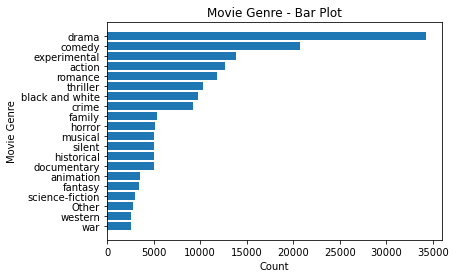

In [36]:
fig, ax = plt.subplots()
n_top_genres = 20 
sorted_genres = genre_per_date.sum(axis=0).sort_values(ascending=False)[:n_top_genres]

ax.barh(sorted_genres.index, sorted_genres.values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_ylabel('Movie Genre')
ax.set_title('Movie Genre - Bar Plot')

plt.show()


We can note that genre, comedy and experimental are part of the top three genres. But what about their evolution throughout time?

In [37]:
# sample per period
window = "5Y"

# chose agg funct from aggfunct = [np.sum,np.cumsum]
cumfunc = None

# normalize every period (sum of the row = 1)
normalize = True

# study the pct_change
pct_change_bool = True


In [38]:
def plot_line(df):
    """function to create interactive plots using plotly_express

    Args:
        df (pd.dataframe): a dataframe having a datetime as index
    """
    fig = px.line(df)

    period = [1,3,5,10,20,30,50,100]
    # Create the financial buttons
    fin_buttons = [  {'count': y, 'label': str(y)+ "YTD", 'step': "year", 'stepmode': "todate"} for y in period ]

    # Create the date range buttons & show the plot
    fig.update_layout({'xaxis': {'rangeselector': {'buttons': fin_buttons}}})
    fig.show()

In [39]:
def genre_per_period(window:str,normalize:bool,pct_change_bool:bool,cumfunc=None):
    """
        genre per period resamples on a certain time windows, and transforms the data to either normalize,
        to mesure the change compared to previous year or to get the cumulative distribution
    Args:
        window (str): the time window we wish to sample the data
        normalize (bool): normalization or not
        pct_change_bool (bool): outputs the percentage of change of the data 
        cumfunc (_type_, optional): cumulative function or not. Defaults to None.

    Returns:
        DataFrame: the result is a newly sampled dataframe that has or not gone through the transformation functions.
    """
    res = genre_per_date.resample(window).sum()
    if not cumfunc==None:
        res = res.apply(cumfunc)
    
    if normalize:
        res = res.div(res.sum(axis=1), axis=0)

    if pct_change_bool:
        res = res.pct_change().fillna(0)
    return res


In [40]:
df= genre_per_period(window=window,cumfunc=cumfunc,normalize=normalize,pct_change_bool=pct_change_bool)

In [41]:
df["max"] = df.max(axis=1)
df["name_max"] = df.idxmax(axis=1)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by="max",ascending=False)


,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,propaganda,religious,romance,science-fiction,silent,thriller,war,western,max,name_max
release_date,,,,,,,,,,,,,,,,,,,,,
1933-12-31,2.672383,0.209726,2.744390,0.124519,0.580867,1.726934,0.728180,0.481297,0.234414,0.728180,...,1.016210,-0.135910,0.648777,0.728180,-0.876243,3.608480,0.218589,-0.026657,22.618461,musical
1923-12-31,-0.172613,1.513300,0.608808,-0.114966,-0.337374,1.229838,0.378979,0.206606,0.097385,0.378979,...,-1.000000,1.757957,1.076215,1.757957,0.064202,1.344264,-0.146347,1.074793,10.031828,family
1943-12-31,1.409100,0.094662,-0.180675,0.035510,-0.139726,-0.064953,-0.647152,1.562791,-0.079527,1.117088,...,6.182977,0.058544,-0.218642,0.242639,-0.911788,0.114942,2.523647,-0.016730,6.182977,propaganda
2018-12-31,2.334376,1.211889,1.005768,-1.000000,-0.410098,-0.493348,-1.000000,-1.000000,-0.539407,-1.000000,...,0.000000,-1.000000,0.290726,5.360684,-1.000000,-0.153748,-1.000000,-1.000000,5.360684,science-fiction
1963-12-31,0.270847,-0.088432,-0.217367,-0.125652,0.094056,-0.003710,0.691047,0.101147,0.111145,4.918664,...,0.076121,0.635704,-0.068433,-0.123482,2.228362,-0.069195,0.089572,-0.368603,4.918664,erotic
1948-12-31,-0.088140,-0.226907,0.165464,-0.235035,-0.160218,0.174148,2.070550,0.041317,0.233933,-0.385890,...,-0.198425,2.991715,0.008650,-0.363145,2.684660,0.710906,-0.160969,-0.165516,2.991715,religious
1953-12-31,0.492460,0.304529,0.021137,-0.103889,0.189369,-0.097896,0.589795,0.222919,0.170265,2.974486,...,-0.897433,-0.021665,0.024715,1.895697,-1.000000,-0.325003,-0.458895,0.164357,2.974486,erotic
2003-12-31,-0.079458,-0.146680,0.001331,-0.201414,0.043694,-0.083320,-0.095054,0.412699,0.014511,-0.165770,...,-1.000000,0.143999,0.087546,-0.187040,2.828619,-0.075187,0.095521,-0.378471,2.828619,silent
1968-12-31,0.337230,0.238792,0.170451,-0.473386,0.106211,0.054579,1.525525,0.381147,-0.159900,0.578453,...,0.736299,0.622068,-0.096925,0.177589,1.315065,0.139217,-0.185440,0.804241,1.525525,diversity


We here have a dataframe (df) that represents the percentage evolution of the normalized data per genre sampled every 5 years and under, an interactive visualisation of this.

In [42]:
plot_line(genre_per_period(window=window,cumfunc=cumfunc,normalize=normalize,pct_change_bool=pct_change_bool))

## Impact of Wars

In [43]:
metagenres = pd.Series(flatten_list(list(metadata.metagenre)))
n_metagenres = len(set(metagenres))
print("Number of genres: {} ".format(n_metagenres))
print(set(metagenres))

Number of genres: 24 
{'silent', 'horror', 'action', 'romance', 'western', 'war', 'animation', 'experimental', 'black and white', 'musical', 'thriller', 'religious', 'documentary', 'Other', 'science-fiction', 'crime', 'comedy', 'family', 'historical', 'fantasy', 'propaganda', 'drama', 'erotic', 'diversity'}


Do violance make people want to watch violence? 

- Add annotations to show where wars happened 
- Add Title
- Modify xlabels

In [118]:
fig = px.line(genre_per_date.resample("3Y").sum().war)
fig.add_vrect(x0=pd.to_datetime(1946, format="%Y"), x1=pd.to_datetime(1939, format="%Y"), 
              annotation_text="WW2")

fig.show()

In [119]:
fig = px.line(genre_per_date.resample("3Y").sum().comedy)
fig.add_vrect(x0=pd.to_datetime(1946, format="%Y"), x1=pd.to_datetime(1939, format="%Y"), 
              annotation_text="WW2")

fig.show()

In [46]:
y_event = 1920
window_y = 1


In [100]:
df_test =  genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
df_test.columns = ["Before","After","Drop"]
df_test.fillna(0,inplace=True)
df_test.drop(columns="Drop",inplace=True)
df_test.head()

,Before,After
Other,2.0,2.0
action,16.0,32.0
animation,0.0,1.0
black and white,173.0,176.0
comedy,92.0,49.0


In [48]:
df_modif = df_test.stack().reset_index().rename(columns={"level_0":"genre","level_1":"Before or after",0:"Value"})
df_modif.head()

,genre,Before or after,Value
0,Other,Before,2.0
1,Other,After,2.0
2,action,Before,16.0
3,action,After,32.0
4,animation,Before,0.0


Text(0.5, 1.0, 'Boxplot')

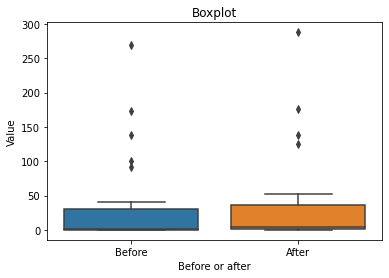

In [49]:
sns.boxplot(data=df_modif, x='Before or after', y='Value');
plt.title("Boxplot")


Text(0.5, 1.0, 'Histogram')

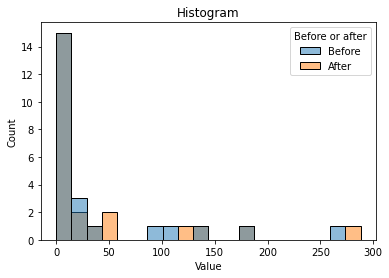

In [50]:
sns.histplot(data=df_modif, hue='Before or after', x='Value',bins=20)
plt.title("Histogram")


In [51]:
genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T

release_date,1919-12-31,1920-12-31,1921-12-31
Other,2.0,2.0,4.0
action,16.0,32.0,18.0
animation,0.0,1.0,1.0
black and white,173.0,176.0,135.0
comedy,92.0,49.0,52.0
crime,15.0,20.0,15.0
diversity,1.0,1.0,0.0
documentary,0.0,1.0,2.0
drama,101.0,125.0,108.0
erotic,0.0,1.0,0.0


In [52]:
df_test

,Before,After
Other,2.0,2.0
action,16.0,32.0
animation,0.0,1.0
black and white,173.0,176.0
comedy,92.0,49.0
crime,15.0,20.0
diversity,1.0,1.0
documentary,0.0,1.0
drama,101.0,125.0
erotic,0.0,1.0


In [53]:
pingouin.ttest( x= df_test.iloc[:,0], y= df_test.iloc[:,1],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.008164,23,two-sided,0.323865,"[-7.38, 2.54]",0.034205,0.339,0.052963


In [54]:
df_test =  genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T

In [55]:
df_test.iloc[:,1]

Other                2.0
action              32.0
animation            1.0
black and white    176.0
comedy              49.0
crime               20.0
diversity            1.0
documentary          1.0
drama              125.0
erotic               1.0
experimental       139.0
family               2.0
fantasy              1.0
historical           5.0
horror               9.0
musical              0.0
propaganda           0.0
religious            1.0
romance             24.0
science-fiction      4.0
silent             288.0
thriller            10.0
war                  4.0
western             53.0
Name: 1920-12-31 00:00:00, dtype: float64

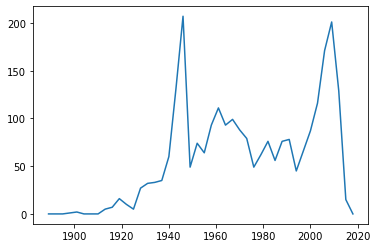

In [56]:
plt.plot(genre_per_date.resample("3Y").sum().war)

In [57]:
len(metadata)

81741

In [58]:
metadata.war.sum()

2664

## Impact of technological advances on cinema

we are going to observe how the apparition of color films and sound in cinema impacted this industry.

In [126]:
def two_trends(event,nb,genre):
    """this is a helper function to help us build some plots with different trends before and after the event

    Args:
        event (dataframe): event is the event dataframe 
        nb (int): this is the number of the event
        genre (str): this is the genre of interest for the plot
    """
    begin = event.iloc[nb,:].begin_date - relativedelta(years=8)
    end = event.iloc[nb,:].begin_date + relativedelta(years=7)
    temp1 = genre_per_date[begin: event.iloc[nb,:].begin_date].resample("2Y").sum()
    temp1['begin'] = '1'
    temp2 = genre_per_date[event.iloc[nb,:].begin_date: end].resample("2Y").sum()
    temp2['begin'] = '0'
    res = pd.concat([temp1,temp2])
    res['time'] = res.index.year
    sns.lmplot(data=res, x='time', y=genre, hue="begin")

In [113]:
fig = px.line(genre_per_date.resample("2Y").sum()['black and white'], title = 'Black and white cinema during the last century')
fig.add_vline(x = pd.to_datetime(1932, format="%Y"))

In [114]:
fig = px.line(genre_per_date.resample("2Y").sum()['silent'], title = 'Silent cinema during the last century')
fig.add_vline(x = pd.to_datetime(1927, format="%Y"))
fig.show()

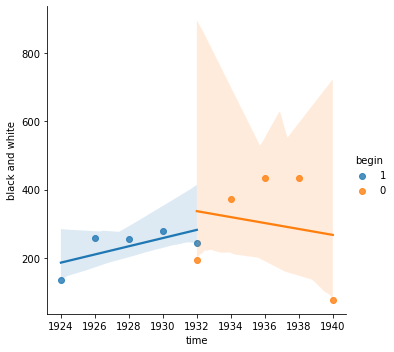

In [129]:
two_trends(event, 12, "black and white")

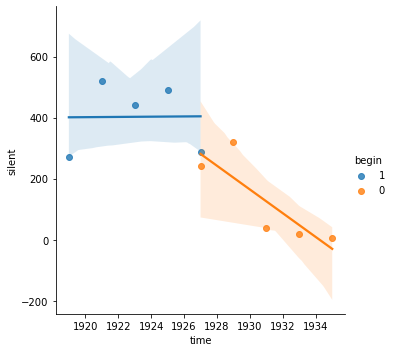

In [127]:
two_trends(event, 10, "silent")